In [400]:
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
# measure
from sklearn.metrics import accuracy_score

# 忽略警告
import warnings

DATASET_DIR = "./dataset"

In [401]:
# 上述函数，其输入是包含1个多个枚举类别的2D数组，需要reshape成为这种数组
# from sklearn.preprocessing import CategoricalEncoder  #后面会添加这个方法

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array

from scipy import sparse

# 后面再去理解
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [402]:
# 另一个转换器：用于选择子集
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

In [403]:
dataset_train_tf = pd.read_csv("./dataset/train.csv")
dataset_test_tf = pd.read_csv("./dataset/test.csv")
combine = [dataset_train_tf, dataset_test_tf]

In [404]:
dataset_train_tf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [405]:
dataset_train_tf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


此图有很多重要的信息：
1. 有接近38%的人存活。(平均值的计算)， 由0，1表示。
2. silsp表示兄弟姐妹，parch表示配偶，一起表示随亲友出行的个数。75%的人都是0， 说明都是单人出行。
3. 将近30%的乘客有兄弟姐妹和/或配偶。
4. 票价差别很大，几乎没有乘客(<1%)支付高达512美元。
5. 几乎没有乘客是65-80岁的。

In [406]:
dataset_train_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [407]:
# 关于类别的信息：
dataset_train_tf.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hassab, Mr. Hammad",male,1601,G6,S
freq,1,577,7,4,644


上图针对类别信息做的统计，表示总数，类别数，出现最多的类别和其次数。

##### 一些猜测
1. 时候女性更容易存活
2. 是否小孩更容易存活
3. 票的类型跟存活有什么关系。

## 分析

In [408]:
# 下列分析不同特征与存活率的区别
dataset_train_tf[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


可以看到船票类型为1的存活率最高，说明有一定的相关性。

In [409]:
# 下列分析不同特征与存活率的区别
dataset_train_tf[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [410]:
# 下列分析不同特征与存活率的区别
dataset_train_tf[["SibSp", "Survived"]].groupby(['SibSp'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [411]:
# 下列分析不同特征与存活率的区别
dataset_train_tf[["Parch", "Survived"]].groupby(['Parch'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


以上是针对不同特征的存活率对比，下面通过可视化来观察。

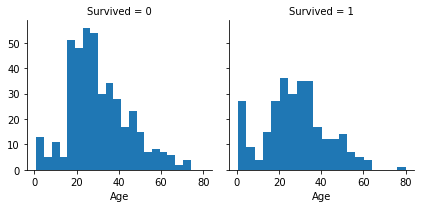

In [412]:
g = sns.FacetGrid(dataset_train_tf, col="Survived")
g.map(plt.hist, "Age", bins=20)

上图是存活与否与年级的关系。有几个点需要注意：
1. 0-4岁的孩子存活率较高
2. 80岁的乘客存活
3. 15-25岁之间有大量的程序死亡
4. 乘客年龄主要集中在15-35岁。

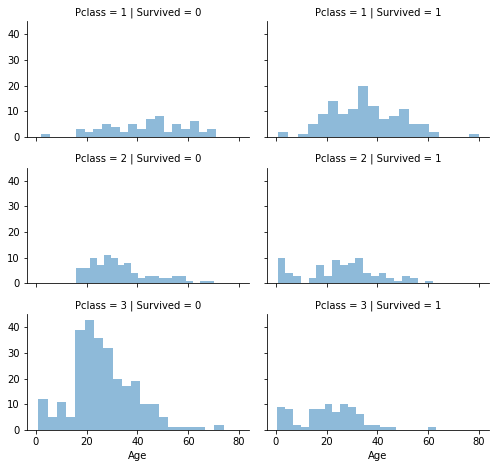

In [413]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(dataset_train_tf, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=20)

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


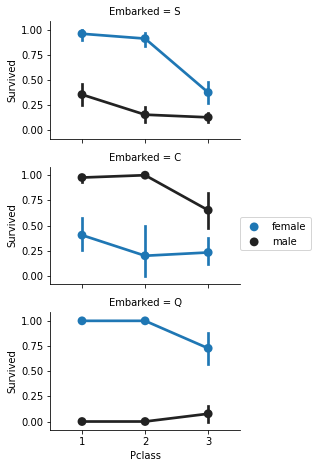

In [414]:
grid = sns.FacetGrid(dataset_train_tf, row="Embarked", size=2.2, aspect=1.6)
grid.map(sns.pointplot, "Pclass","Survived", "Sex", paltte="deep")
grid.add_legend()

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


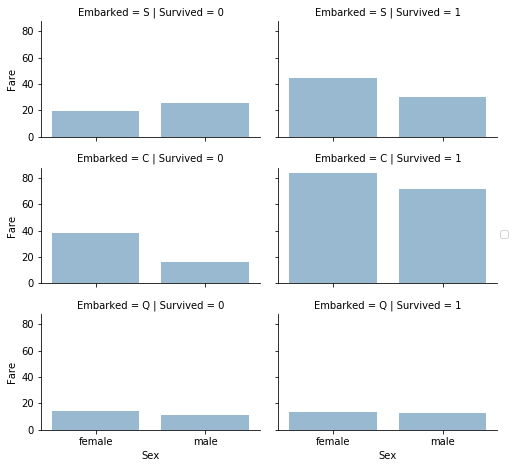

In [415]:
grid = sns.FacetGrid(dataset_train_tf, row="Embarked", col="Survived", size=2.2, aspect=1.6)
grid.map(sns.barplot, "Sex", "Fare", alpha=0.5, ci=None)
grid.add_legend()

In [416]:
# 一些可视化
# 数据间的相互关系
corr_matrix = dataset_train_tf.corr()

In [417]:
corr_matrix["Survived"].sort_values() #数据建的相互相关， 1， -1 最有用

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

如上信息可以知道大概的数据分布， 数值型和类别型信息，以及特征为空的情况。

In [418]:
# 针对姓名用正则表达式匹配称呼
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)

In [419]:
pd.crosstab(dataset_train_tf["Title"], dataset_train_tf["Sex"])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


可以看到不同的称呼的存活率不一样。 简单合并一下：

In [420]:
for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [421]:
# 替换完之后做一个统计
pd.crosstab(dataset_train_tf["Title"], dataset_train_tf["Sex"])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


In [422]:
dataset_train_tf[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [423]:
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in combine:
#     dataset["Title"] = dataset["Title"].map(title_mapping)
#     dataset["Title"] = dataset["Title"].fillna(0)
# dataset_train_tf.head()

#### 下面对年龄的缺失值进行分析
针对缺失值，一般有3种方法：删除该特征， 删除该实例，用中位数或者均值不全。  
如果要更精确的值，可以根据该实例的其他特征与其他实例的相似度，来对年龄进行填充。

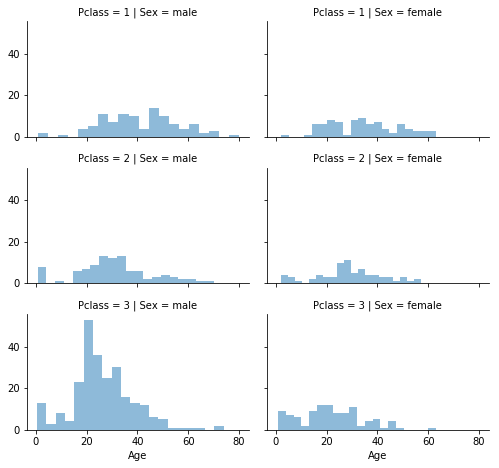

In [424]:
grid = sns.FacetGrid(dataset_train_tf, row="Pclass", col="Sex", size=2.2, aspect=1.6)
grid.map(plt.hist, "Age", alpha=.5, bins=20)

如上可以观察到不同Pclass和Sex下缺失年龄的值。因此可以根据相似来补全年龄。

In [425]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [426]:


guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)
            age_guess = guess_df.median()

            
            

#             Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)



In [427]:
dataset_train_tf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,Mr


In [428]:
# 将数据分为不同的年龄段进行分析(这次age的补全提高了精确度)
# dataset_train_tf["AgeBand"] = pd.cut(dataset_train_tf["Age"], 5)
# dataset_train_tf[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

不同年龄段下的存活率对比。

In [429]:
# 进行一个转换, 由于降低精确度，暂时不采用。
# for dataset in combine:    
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age']
# dataset_train_tf.head()

### 对特征进行组合

In [430]:
# 创造一个亲属特征
# for dataset in combine:
#     dataset["FamilySize"] = dataset['SibSp'] + dataset['Parch'] + 1
# dataset_train_tf[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [431]:
# for dataset in combine:
#     dataset["IsAlone"] = 0
#     dataset.loc[dataset["FamilySize"] == 1, "IsAlone"] = 1
# dataset_train_tf[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

对于独自乘船的旅客，存活率30%。

In [432]:
# for dataset in combine:
#     dataset['Age*Class'] = dataset.Age * dataset.Pclass

# dataset_train_tf.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

In [433]:
# corr_matrix = dataset_train_tf.corr()
# corr_matrix["Survived"].sort_values() #数据建的相互相关， 1， -1 最有用

In [434]:
dataset_train_tf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,Mr


In [435]:
# 分开类别和数值型数据
num_attribute = ["Pclass", "Age","Fare", "SibSp", "Parch"]
cat_attribute = ["Embarked", "Sex", "Title"]

In [436]:
dataset_train_tf["Embarked"] = dataset_train_tf["Embarked"].fillna("S")
# dataset_train_tf = dataset_train_tf.drop(["Cabin"], axis=1)

In [437]:
num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribute)),
    ("imputer", Imputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribute)),
    ("cat_encoder", CategoricalEncoder(encoding="onehot-dense"))
#     ("label", LabelBinarizer())
])


In [438]:
# dataset_train_tf["Embarked"].values

In [439]:
# dataset_num_pipeline = num_pipeline.fit_transform(dataset_tf)
# dataset_cat_pipeline = cat_pipeline.fit_transform(dataset_train_tf)
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [440]:
dataset_full_pipeline = full_pipeline.fit_transform(dataset_train_tf)

In [441]:
dataset_full_pipeline.shape

(891, 15)

In [442]:
dataset_train = dataset_full_pipeline
dataset_label = dataset_train_tf["Survived"]

In [443]:
train_X, test_X, train_y, test_y = train_test_split(dataset_train, dataset_label, test_size=0.2, random_state=42)

In [444]:
# # model 
# log_reg = LogisticRegression()
# log_reg.fit(train_X, train_y)

In [445]:
# predict_y = log_reg.predict(test_X)
# accuracy_score(test_y, predict_y)

In [446]:
from sklearn.ensemble import RandomForestClassifier
rdf_cla = RandomForestClassifier(n_estimators=500)
rdf_cla.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [447]:
predict_y = rdf_cla.predict(test_X)
accuracy_score(test_y, predict_y)

0.8435754189944135

In [448]:
# from sklearn.ensemble import GradientBoostingClassifier
# gb_cla = GradientBoostingClassifier(n_estimators=500)
# gb_cla.fit(train_X, train_y)

In [449]:
# predict_y = gb_cla.predict(test_X)
# accuracy_score(test_y, predict_y)

In [453]:
from sklearn.model_selection import cross_val_score # 交叉验证
scores = cross_val_score(rdf_cla, train_X, train_y, cv=5)

In [454]:
scores

array([0.83216783, 0.78321678, 0.7972028 , 0.78873239, 0.81560284])

In [451]:
# # 去预测给出测试数据的精确度
# dataset_test_full_pipeline = full_pipeline.transform(dataset_test_tf)
# predict_y = log_reg.predict(dataset_test_full_pipeline)
# result =pd.DataFrame({
#         "PassengerId": dataset_test_tf["PassengerId"],
#         "Survived": predict_y
#     })
# result.to_csv("result.csv", index=False)